In [164]:
import pandas as pd
import numpy as np
from string import punctuation
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import nltk 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv('E:\\python__\\books_data.csv')
df = df[['Title', 'image','description']]                                     # 필요 변수만

df = df.dropna(axis = 0, how = 'any')                                         # 결측지 제거

# np.random.seed(123)
# label = np.random.randint(0,len(df),130000)                                     # 데이터 수가 너무 많아서 7000개 랜덤으로 추출
# df = df.iloc[label].reset_index()
# del df['index']

In [165]:
df.describe()   # 줄거리 중복값이 많음

,Title,image,description
count,136957,136957,136957
unique,136957,128479,126531
top,Dr. Seuss: American Icon,http://books.google.com/books/content?id=dPucx...,Unlike some other reproductions of classic tex...
freq,1,28,92


In [166]:
df = df.drop_duplicates('description')    # 중복값 제거 데이터프레임 생성
df.index = range(len(df))    # 인덱스 재지정
df

In [169]:
df_title = df.Title.copy()
df_des = df.description.copy()

In [170]:
df_des   # 전처리할 데이터

0         Philip Nel takes a fascinating look into the k...
1         This resource includes twelve principles in un...
2         Julia Thomas finds her life spinning out of co...
3         In The Church of Christ: A Biblical Ecclesiolo...
4         The story for children 10 and up of St. Hyacin...
                                ...                        
126526    Autodesk Inventor 2017 Essentials Plus provide...
126527    During a school trip to Ellis Island, Dominick...
126528    Everyone in the village of Friedensdorf is hap...
126529    Alex-Li Tandem sells autographs. His business ...
126530    Discover the many ways mathematics is relevant...
Name: description, Length: 126531, dtype: object

# 데이터 전처리

In [174]:
def NLTK_des(data):
    
    data = data.str.lower()     # 소문자 변경
    
    nltk.download('punkt')
    nltk.download('stopwords')
    
    stw = stopwords.words('english')   # 불용어
    stw.extend(["'s", "’", "’", "''", "``", "--"])    # 불용어 + punctuation에 없는 특수문자들

    des_token = []

    for i in range(len(data)):
        result = []
        for w in word_tokenize(data[i]):
            if ((w not in stw) and (w not in punctuation)):
                result.append(w)
                tmp = " ".join(result)
        des_token.append(tmp)

    return pd.Series(des_token)


NLTK_des(df_des)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ska06\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ska06\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0         philip nel takes fascinating look key aspects ...
1         resource includes twelve principles understand...
2         julia thomas finds life spinning control death...
3         church christ biblical ecclesiology today resp...
4         story children 10 st. hyacinth dominican plant...
                                ...                        
126526    autodesk inventor 2017 essentials plus provide...
126527    school trip ellis island dominick avaro ten-ye...
126528    everyone village friedensdorf happily preparin...
126529    alex-li tandem sells autographs business hunt ...
126530    discover many ways mathematics relevant life m...
Length: 126531, dtype: object

# Word2vec 학습 
<br>

### 여기서부턴 온갖 구글링에 시달린 코드들 중 일부입니다.
### 어찌저찌 Word2vec으로 단어들 간 유사도는 찾았는데 신뢰하기에는 어려운 결과값으로 추정됩니다.

In [175]:
corpus = NLTK_des(df_des).str.split()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ska06\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ska06\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [176]:
corpus

0         [philip, nel, takes, fascinating, look, key, a...
1         [resource, includes, twelve, principles, under...
2         [julia, thomas, finds, life, spinning, control...
3         [church, christ, biblical, ecclesiology, today...
4         [story, children, 10, st., hyacinth, dominican...
                                ...                        
126526    [autodesk, inventor, 2017, essentials, plus, p...
126527    [school, trip, ellis, island, dominick, avaro,...
126528    [everyone, village, friedensdorf, happily, pre...
126529    [alex-li, tandem, sells, autographs, business,...
126530    [discover, many, ways, mathematics, relevant, ...
Length: 126531, dtype: object

In [179]:
model = Word2Vec(sentences = corpus, vector_size = 100,window=5, min_count = 50, workers=4, sg=0)

In [181]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.7916184067726135), ('stranger', 0.6166614890098572), ('boy', 0.615292489528656), ('girl', 0.6116724610328674), ('reckless', 0.586303174495697), ('englishman', 0.5835949778556824), ('widow', 0.5734294056892395), ('outsider', 0.5637872219085693), ('person', 0.5598617792129517), ('naive', 0.5596503019332886)]


In [183]:
i_list = []
j_list = []
for i, j in model_result:
    i_list.append(i)
    j_list.append(j)
plo = pd.DataFrame({'name' : i_list, 'prob': j_list})
plo

,name,prob
0,woman,0.791618
1,stranger,0.616661
2,boy,0.615292
3,girl,0.611672
4,reckless,0.586303
5,englishman,0.583595
6,widow,0.573429
7,outsider,0.563787
8,person,0.559862
9,naive,0.559650


# 책 표지 사진 불러오기
<br>

### 아래 코드를 이용해서 뭔가 더 좋은 시각자료를 출력할 수 있을 것 같습니다.

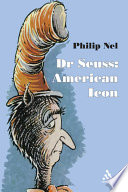

In [185]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get(df1.iloc[0].image)
img = Image.open(BytesIO(response.content))
img

# ↓ 실패 코드들

In [36]:
def Title_scale(data):

    data = data.str.lower()                                         # 소문자
    ti = data

    ti_list = []
    for i in range(len(data)):
        ti_tmp = [i for i in list(data[i]) if i not in punctuation]       # 특수문자
        ti_s = "".join(ti_tmp)
        ti_list.append(ti_s)

    for j in range(len(data)):                                                  # 띄어쓰기 2번 되어있는 것들
        a = ""
        for i in ti_list[j].split():
            a += (" " + i)
        ti_list[j] = a.strip()
   #     df1.Title = pd.Series(ti_list)

    return pd.Series(ti_list)


def Ti_eng(data):
    stop_words = set(stopwords.words('english')) 
    ti_eng = []

    for i in range(len(data)):
        result = []
        for t in data[i].split(): 
            if t not in stop_words: 
                result.append(t)
                d = " ".join(result)       
        ti_eng.append(d)
   # df1.description = pd.Series(des_eng)
    
    return pd.Series(ti_eng)

In [261]:
def Des_scale(data):

    data = data.str.lower()
    de = data

    de_list = []
    for i in range(len(data)):
        de_tmp = [i for i in list(data[i]) if i not in punctuation]
        de_s = "".join(de_tmp)
        de_list.append(de_s)

    for j in range(len(data)):
        b = ""
        for i in de_list[j].split():
            b += (" " + i)
        de_list[j] = b.strip()
       # df1.description = pd.Series(de_list)

        return pd.Series(de_list)
    
    
    
def Des_eng(data):
    stop_words = set(stopwords.words('english')) 
    des_eng = []

    for i in range(len(data)):
        result = []
        for t in data[i].split(): 
            if t not in stop_words: 
                result.append(t)
                c = " ".join(result)       
        des_eng.append(c)
   # df1.description = pd.Series(des_eng)
    
    return pd.Series(des_eng)

# ↑ 실패 코드들

In [178]:
# 구글링으로 얻어낸 라이브러리들 (다 쓰지는 않음)
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

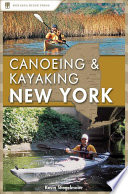

In [208]:
#책 표지 사진 불러오기
from PIL import Image
import requests
from io import BytesIO

response = requests.get(df1.iloc[0].image)
img = Image.open(BytesIO(response.content))
img